<a name="top"> <h1>3.5. Support Vector Machine</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">


### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Carga de datos](#datos) 

[3. Creación del modelo](#creacion) 

   
[4. Optimización del modelo](#optimizacion) 

   
[5. Predicción del modelo y análisis de sus métricas](#prediccion)

[6. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F0.5, F1
   - Curva ROC y Lift

<hr style="border:1px solid gray">


# <a name="introduccion"> 0. Introducción <a> 

El modelo de **Support Vector Machine (SVM)** es un algoritmo de aprendizaje supervisado utilizado para clasificación y regresión. Funciona buscando un hiperplano en un espacio de n-dimensiones que maximice la margen entre las diferentes categorías. Los datos se representan como puntos en el espacio y el objetivo del SVM es encontrar el hiperplano que mejor separe los diferentes grupos de puntos.

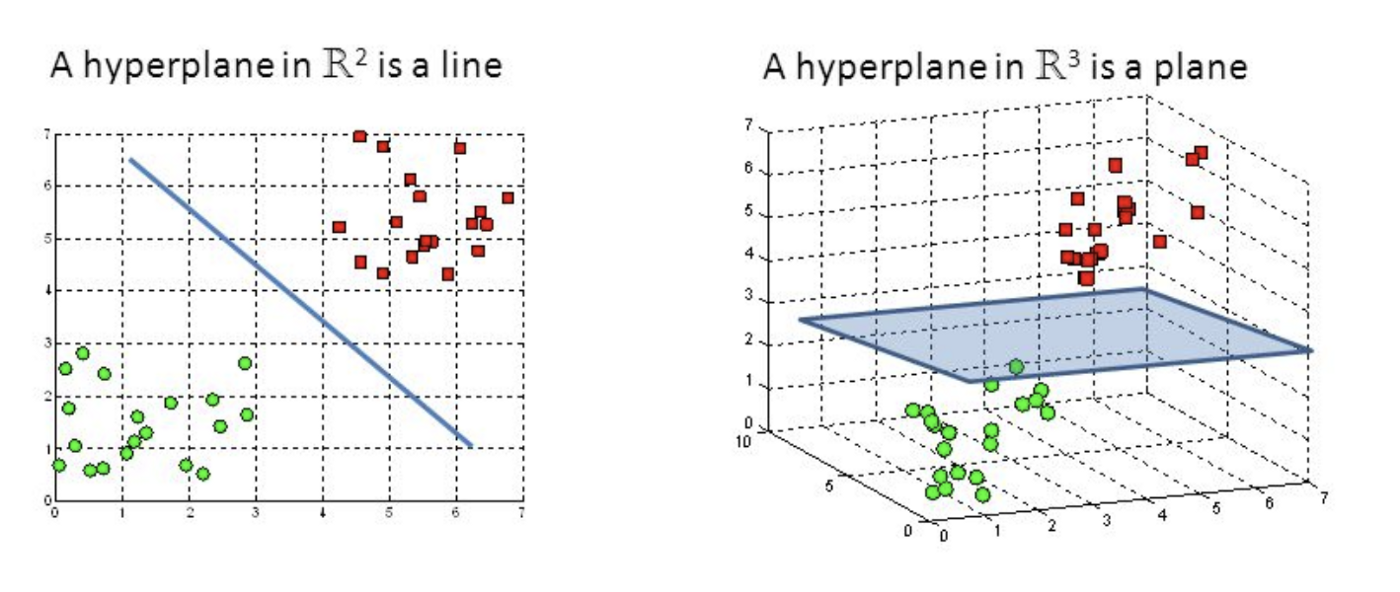

# <a name="librerias"> 1. Importación de librerias y funciones <a> 

In [1]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score,roc_auc_score,plot_confusion_matrix,accuracy_score

# Import sklearn models and pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn import svm

Importamos las funciones a utilizar:

In [2]:
# Import the functions used in the notebook.

from aux_functions import load_model, save_model

Cargamos el pickle de preprocesado, para su posterior uso:

In [3]:
# Import the preprocessor.

preprocessor = load_model('../models/preprocessor.pickle')

# <a name="datos"> 2. Carga de datos <a> 

En primer lugar procederemos a cargar los datos de train y validación que insertaremos dentro del modelo para su optimización y predicción.

In [4]:
# Load the train dataset separated by other variables and target.

x_train = pd.read_parquet("../data/processed/x_train.parquet").reset_index(drop=True)
y_train = pd.read_parquet("../data/processed/y_train.parquet").reset_index(drop=True)

# Load the validation dataset separated by other variables and target.

x_val = pd.read_parquet("../data/processed/x_val.parquet")
y_val = pd.read_parquet("../data/processed/y_val.parquet")

# <a name="creacion"> 3. Creación del modelo <a> 

Procedemos a usar el **algorítmo SVC** junto con el preprocesado correspondiente, utilizaremos el algoritmo lineal para clasificar los datos. 

In [5]:
# Design the parameters.

kernel = 'linear'
probability = True
random_state = 12345

# Create a pipeline that applies a data preprocess and then the Support Vector Machine model.

model_SVM = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', svm.SVC(kernel=kernel, probability=probability, random_state=random_state))

])

# <a name="optimizacion"> 4. Optimización del modelo <a> 

Optimizamos el modelo a través del pipeline creado anteriormente, para ello introduciremos los valores de train.

In [6]:
# Optimization of the svm with the train set: input and target data. 

model_SVM.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('short_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['attributes_ByAppointmentOnly',
                                                   'attributes_BusinessAcceptsCreditCards',
                                                   'attributes_BikeParking',
                                                   'attributes_RestaurantsPriceRange2',
                                                   'attributes_...
                                                   'attributes_BYOBCorkage',
                                                   'attributes_AgesAllowed']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['review_count',
                                                   'total_hours_Monday',
                                                   'total_hours_Tuesday',
                                                   'total_hours_Wednesday',
                                                   'total_hours_Thursday',
                                                   'total_hours_Friday',
                                                   'total_hours_Saturday',
                                                   'total_hours_Sunday',
                                                   'total_checkins'])])),
                ('clasificador',
                 SVC(kernel='linear', probability=True, random_state=12345))])

Una vez optimizado el modelo Support Vector Machine, con el set de train, procedemos a guardarlo en un pickle para que no tenga que volver a computarlo en un futuro, por si quisieramos usarlo.

In [7]:
# Save the backup of the gradient boosting optimziation as a pickle file.

save_model(model_SVM,'../models/Support_Vector_Machine.pickle')

Para evitar ejecutar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.

In [6]:
# Load the SVM model already fitted in /models.

model_SVM = load_model('../models/Support_Vector_Machine.pickle')

# <a name="prediccion"> 5. Predicción del modelo <a> 

Una vez realizada la optimización del modelo Support Vector Machine, procederemos a predecir el set de validación, sus valores y probabilidades. Para posteriormente obtener las métricas y observar como se comporta el modelo y su score.

In [7]:
# Predict the target value of the validation set.

predictions = model_SVM.predict(x_val)

# Predict the probabilities of the target value for validation set.

predict_probabilities = model_SVM.predict_proba(x_val)

Una vez obtenidas las probabilidades, representamos el histograma de densidad de la predicción:

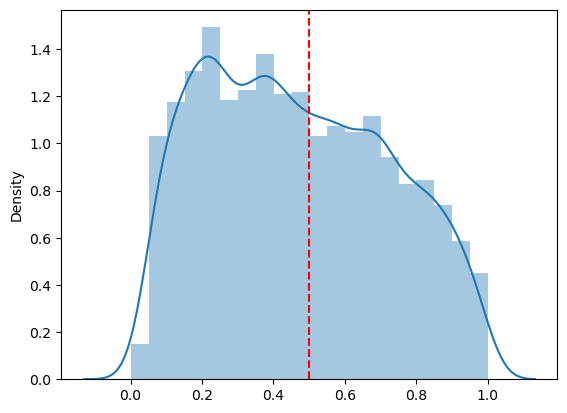

In [8]:
# Parametric density histogram of the predicted probabilities, shwoing the treshold of 0.5.

sns.distplot(predict_probabilities[:,1], kde=True, rug=False, bins=20)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()

Observando el histograma de densidad de las probabilidades observamos como el modelo asigna a un mayor número de observaciones probabilidades bajas.

# <a name="metricas"> 6. Evaluación de las métricas del modelo <a> 

En este apartado procederemos a análizar las métricas obtenidas. Nos centraremos principalmente en la métrica F0.5 , dado que es la que mejor refleja los resultados del modelo para nuestro problema. En el caso de que se quiera consultar la definición de cada una de ellas, se pueden encontrar en el documento `02_DummyModel`. 

### 6.1. Matriz de confusión

Confusion matrix, without normalization
[[2616  809]
 [ 951 2096]]
Normalized confusion matrix
[[0.76379562 0.23620438]
 [0.31211027 0.68788973]]


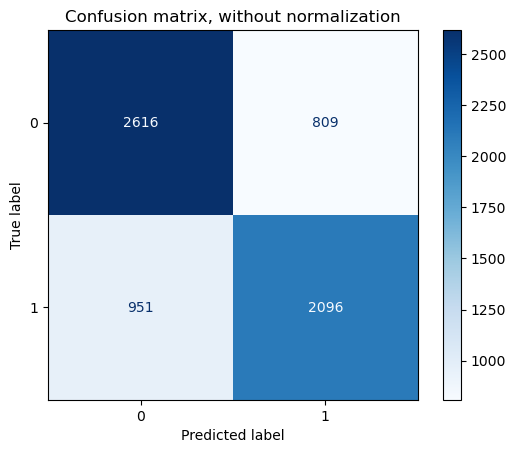

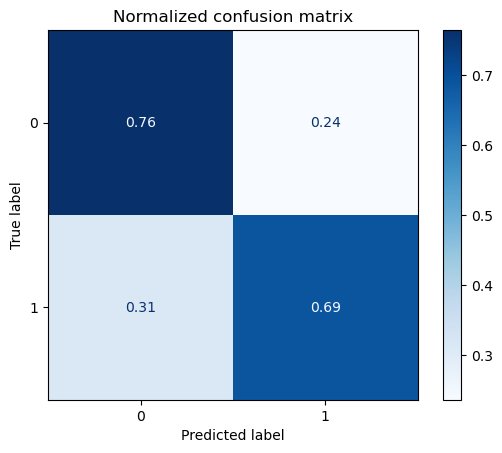

In [9]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model_SVM, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

La matriz de confusión nos deja ver que de los modelos que hemos estimado es el que peor resultado presenta, puesto que comete un fallo de un 31% identificandolo como calificación baja cuando en realidad es alta.

### 6.2. Métricas: Accuracy, Recall, Precision, F0.5 y F1 score

In [10]:
# Print the general metrics.

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      3425
           1       0.72      0.69      0.70      3047

    accuracy                           0.73      6472
   macro avg       0.73      0.73      0.73      6472
weighted avg       0.73      0.73      0.73      6472



In [11]:
# Model Accuracy

print("Accuracy:",accuracy_score(y_val, predictions))


# F 0.5 score.

print('F0.5 score is ' +str(fbeta_score(y_val, predictions, average='binary', beta=0.5)))

Accuracy: 0.7280593325092707
F0.5 score is 0.7145292152451082


Para poder reflejar la capacidad predictora del modelo utilizaremos el Accuracy y el Recall.

- El modelo nos calcula un **Recall de 0.73**, por lo que el modelo es capaz de identificar un 73% de casos en los que hay una valoración alta. 


- El modelo nos calcula un **Accuracy de 0.73**, por lo que el modelo es capaz de acertar en el 73% de los casos. 


- **El modelo nos calcula un F0.5 de 0.71, por lo que el modelo es capaz de diferenciar falsos positivos en el 71% de los casos. Esta medida es la que utilizaremos para compararlo con el resto de modelos**

### 6.3. Curva ROC y Lift

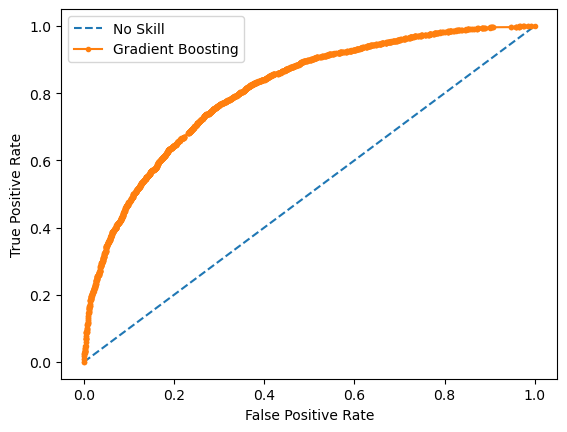

The Compute Area Under the Receiver Operating Characteristic is 0.8080107033602515


In [14]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(roc_auc_score(y_val,yhat)))

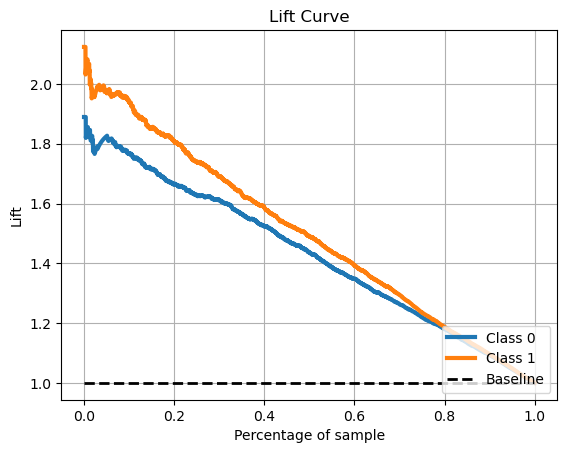

In [10]:
# Plot the lift curve.

skplt.metrics.plot_lift_curve(y_val, predict_probabilities)
plt.show()

  **La curva ROC muestra un resultado similar a los modelos anteriores pero no el máximo, con un 0.8.**
  
 En cuanto a la curva lift, podemos observar que el modelo es muy similar a la de los otros modelos analizados anteriormente.

[Ir arriba del documento](#top)